### Nuißl Sandra, 14.08.2023
## "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen"
### - Implementierung und Evaluierung der Topic Modelling Modelle: Top2Vec -

<hr>

## **Inhaltsverzeichnis**

<ul>1. Aufbau des Jupyter Notebooks</ul>
<ul>2. Instalation und Imports</ul>
    <ul>
     <ul>2.1. Installationen</ul>
     <ul>2.2. Imports</ul>
    </ul>
<ul>3. Laden der bereinigten Amazon Daten</ul>
<ul>4. Implementierung des Modells</ul>
    <ul>
     <ul>4.1. Data Preparation</ul>
     <ul>4.2. Modellierung</ul>
     <ul>4.3. Visualisierung</ul>
    </ul>
<ul>5. Evaluierung</ul>
    <ul>
     <ul>5.1. Coherence score</ul>
     <ul>5.2. Perplexity</ul>
     <ul>5.3. Similarity</ul>
    </ul>
<ul>6. Literaturverzeichnis</ul>
<hr>

## 1. Aufbau des Jupyter Notebooks
Dieses Jupyter Notebook ist Teil der Master Thesis "Empirische Evaluation von ‚State Of The Art‘ Topic Modeling Ansätze am Beispiel von Produktreviews für die Entscheidungsunterstützung in Unternehmen".
Es beinhaltet die Implementierung des Topic Modelling Modells von __Top2Vec__ sowie dessen Evaluierung.

Die theoretischen Inhalte zu diesem Notebook sind der schriftlichen Ausarbeitung dieser Masterarbeit unter den Kapiteln "5. 3.	Top2Vec" und "6.	Empirische Evaluierung der Modelle" zu entnehmen.

## 2. Instalationen und Imports
### 2.1. Installationen

In [ ]:
# Instalationen
%pip install nltk
%pip install tables
%pip install gitly==1.0.1
%pip install plotly>4.0.0
%pip install top2vec
%pip install gensim
%pip install umap-learn
%pip install hdbscan

### 2.2. Imports

In [ ]:
# Imports und Initalisierungen
import numpy as np
import pandas as pd
import tables

# Beschleunigung
import joblib
from joblib import Parallel, delayed

# Progressbar
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from tqdm.auto import tqdm
tqdm_notebook.pandas()

# Natural Language Processing
import nltk
from nltk import word_tokenize
nltk.download('punkt')

# Datenvisualisierung
import plotly.express as px
import plotly.figure_factory as ff
from gitly.colab.plot import GitlyPlotter
gitly = GitlyPlotter('github')              # Instanziierung des Objekts

# Modelling
from gensim.models import Word2Vec
from top2vec import Top2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from umap import UMAP
from hdbscan import HDBSCAN

# Evaluierung
from gensim.models import CoherenceModel
import gensim.corpora as corpora
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Laden der bereinigten Amazon Daten

In [4]:
# Review Daten laden
reviews_df = pd.read_hdf('Cleaned_Sport_and_Outdoors.h5')

# Ausgabe
pd.concat([reviews_df], axis=1, sort = False, keys = ["Bereinigter Datensatz: Sport and Outdoors"])

Bereinigter Datensatz: Sport and Outdoors  \
                                                reviewText   
0                  What a spectacular tutu! Very slimming.   
1        What the heck? Is this a tutu for nuns? I know...   
2                        Exactly what we were looking for!   
3        I used this skirt for a Halloween costume and ...   
4        This is thick enough that you can't see throug...   
...                                                    ...   
2264636                     Wife laughs at me but it works   
2264637  2XU makes great compression shorts. A bit more...   
2264638  These are my favorite compression shorts for r...   
2264639  Love the shorts.. amazing comfortable, perfect...   
2264640  I have a briley bolt release paddle installed ...   

                                                                          \
                                               cleanedText  year overall   
0                               spectacular tutu veri slim  2015     5.0   
1        heck tutu nun know cut still also nt sever lay...  2015     1.0   
2                                               exact look  2015     5.0   
3        use skirt halloween costum glue bunch feather ...  2014     5.0   
4        thick enough ca nt see veri long sure check di...  2014     4.0   
...                                                    ...   ...     ...   
2264636                                    wife laugh work  2018     4.0   
2264637  xu make great compress short bit expens well w...  2018     5.0   
2264638  favorit compress short run thinnest materi run...  2018     5.0   
2264639  love short amaz comfort perfect compress perfe...  2018     5.0   
2264640  briley bolt releas paddl instal a xplor sport ...  2017     5.0   

                                                                      \
            brand                                              title   
0        BubuBibi                           Adult Ballet Tutu Yellow   
1        BubuBibi                           Adult Ballet Tutu Yellow   
2        BubuBibi                           Adult Ballet Tutu Yellow   
3        BubuBibi                           Adult Ballet Tutu Yellow   
4        BubuBibi                           Adult Ballet Tutu Yellow   
...           ...                                                ...   
2264636  Columbia                               Columbia Bora booney   
2264637       2XU                  2XU Men's Core Compression Shorts   
2264638       2XU                  2XU Men's Core Compression Shorts   
2264639       2XU                  2XU Men's Core Compression Shorts   
2264640       STS  T&amp;s Shell Catcher Beretta A400 Multitarget...   

                     
               asin  
0        0000032034  
1        0000032034  
2        0000032034  
3        0000032034  
4        0000032034  
...             ...  
2264636  B01HJDZ34I  
2264637  B01HJGAJ9O  
2264638  B01HJGAJ9O  
2264639  B01HJGAJ9O  
2264640  B01HJHHBHG  

[2264641 rows x 7 columns]

#### __Verleinerung des Datensatzes__
Top2Vec ist der Lage größere Datenmengen zu verarbeiten. Jedoch benötigt die Verwendung von UMAP große Kapazitäten der System-RAM. Da im Rahmen dieser Masterarbeit durch die begrenzten RAM der Datensatz verkeleinert werden musste, wird für alle Topic Modelling Modelle der gleiche Datensatz verwendet. Dadurch können die Ergebnisse der Evaluierung besser verglichen werden.

In [5]:
# Verleinerung des Datensatzes Aufgrund der Performence
reviews_df = reviews_df.iloc[ :100000,]

## 4. Implementierung des Modells

### 4.1. Data Perparation
Für Top2Vec ist in der Regel keine Vorverarbeitung der Daten notwendig. Für spätere Analysen werden jedoch die bereinigten Daten tokenized.

In [6]:
# Definition einer Funktion zum Splitten der Texte in Token
def split_text(in_string):
  out_string = in_string.split()
  return out_string

In [7]:
# Tokenisierung
# Quelle: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
reviews_df["Token"] = Parallel(n_jobs=-1)(delayed(split_text)(text) for text in tqdm(reviews_df["cleanedText"],
                                                                                     desc ="Status Tokenizierung: ",
                                                                                     total = len(reviews_df)))

# Speichern der Sätze in einer Liste
sentence_list = reviews_df.reviewText.values.tolist()

# Ausgabe
reviews_df.head(3)

Status Tokenizierung:   0%|          | 0/100000 [00:00<?, ?it/s]

,reviewText,cleanedText,year,overall,brand,title,asin,Token
0,What a spectacular tutu! Very slimming.,spectacular tutu veri slim,2015,5.0,BubuBibi,Adult Ballet Tutu Yellow,0000032034,"[spectacular, tutu, veri, slim]"
1,What the heck? Is this a tutu for nuns? I know...,heck tutu nun know cut still also nt sever lay...,2015,1.0,BubuBibi,Adult Ballet Tutu Yellow,0000032034,"[heck, tutu, nun, know, cut, still, also, nt, ..."
2,Exactly what we were looking for!,exact look,2015,5.0,BubuBibi,Adult Ballet Tutu Yellow,0000032034,"[exact, look]"


### 4.2. Bestimmung der Parameter

#### __Embedding__

Zu Beginn des Modells werden Einbettungsvektoren erzeugt, um die Reviews in einem Mehrdimensionalen Raum abbilden zu können. Für Top2Vec wird hierfür das Embedding Modell „Doc2Vec“ herangezogen. Es Basiert auf dem Modell "Word2Vec", welches mithilfe eines Bag of Word Ansatzes sogenannte Wortvektoren erstellt. Im Anschluss findet eine Erweiterung um einen dokumentenspezifischen Merkmalsvektor statt, welcher auch unter dem Namen „Distributed Memory-Version von Paragraf Vector“ bekannt ist. Dieser Vektor stellt das Gedächtnis des Algorithmus dar, welches sich an den Kontext bzw. das Thema des Absatzes erinnert. Zusammenfassend lässt sich sagen, dass „Doc2Vec“ das Konzept der Wörter über den Wortvektor mit dem Kontext eines Dokuments über den Dokumentenvektor miteinander kombiniert und auf diese Wiese die Semantik und Reihenfolge eines Textes berücksichtigt (Le & Mikolov, 2014, S. 3 f.)

In [ ]:
# Schritt 1 - Embadding
# Quelle: https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
# Taggen der Dokumente
tagged_list = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(sentence_list)]

# Intialisierung des Modells (Doc2Vec)
embedding_model = Doc2Vec(vector_size=30, window=5, min_count=1, workers=4)
embedding_model.build_vocab(tagged_list)
embedding_model.train(tagged_list, total_examples=embedding_model.corpus_count, epochs=10)

In [ ]:
# Durchführung der Vektorisierung
# Quelle: https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
# Erstellen einer leeren Liste für die Vektoren
vector_list = []

# Erstellen der Embeddings
for i in range(len(sentence_list)):
    vector = embedding_model.docvecs[str(i)].tolist()
    vector_list.append(vector)

#### __Dimensionsreduktion__

Befor die Daten in Topics geclustert werden können, ist es wichtig die Dimensionen der Vekoren zu reduzieren. Abhängig vom Embedding Model können diese bis zu 512 Komponenten enhalten. Top2Vec verwendet hierfür UMAP mit seinen Default Parameter (Mavuduru, 2021). Das Modell hat den Vorteil bei niedriger Dimensionalität die lokalen hochdimensionalen Strukturen zu erhalten. Hierfür muss U ggf. „umap-learn“ mithilfe von „pip install“ installiert werden (Grootendorst, Topic Modeling with BERT, 2020).

In [10]:
# Schritt 2 - Dimensionsreduktion
# Quelle: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview
umap_model = UMAP(n_neighbors=15, n_components=3, min_dist=0.1, metric='cosine', verbose=True)

In [11]:
# Durchführen der Dimensionsreduktion
umap_embeddings = umap_model.fit_transform(vector_list)

UMAP(angular_rp_forest=True, metric='cosine', n_components=3, verbose=True)
Tue Aug  8 18:20:30 2023 Construct fuzzy simplicial set
Tue Aug  8 18:20:30 2023 Finding Nearest Neighbors
Tue Aug  8 18:20:30 2023 Building RP forest with 21 trees
Tue Aug  8 18:20:37 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	 7  /  17
	Stopping threshold met -- exiting after 7 iterations
Tue Aug  8 18:21:04 2023 Finished Nearest Neighbor Search
Tue Aug  8 18:21:08 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Aug  8 18:22:21 2023 Finished embedding


#### __Clustering__

Top2Vec verwendet für das Clustering der Topics das Modell HDBSCAN, welches ebenfalls als Parameter in das Topic Modelling Modell übergeben wird. Es ist ein hierarchisch - dichtebasierter Algorithmus, welche dichte Bereiche von Dokumenten zu finden (Mavuduru, 2021). Mithilfe der Parrallelisierung der verfügbaren CPU Kerne kann Prozess beschleunigt werden (McInnes, Healy, & Astels, 2016).

In [12]:
# Schritt 3 - Clustering
# Quelle: https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview
hdbscan_model = HDBSCAN(min_cluster_size=14,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        min_samples=1,
                        prediction_data=True,
                        core_dist_n_jobs=-1)

In [13]:
# Durchführen des Clusterings
cluster = hdbscan_model.fit(umap_embeddings)

In [18]:
# Speichern der Informationen in einen DataFrame
# Quelle: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6
result_df = pd.DataFrame(umap_embeddings, columns=['x', 'y', 'z'])
result_df['labels'] = cluster.labels_

# Trennen der Cluster von den Ausreißern
outliers_df = result_df.loc[result_df.labels == -1, :]
clustered_df = result_df.loc[result_df.labels != -1, :]

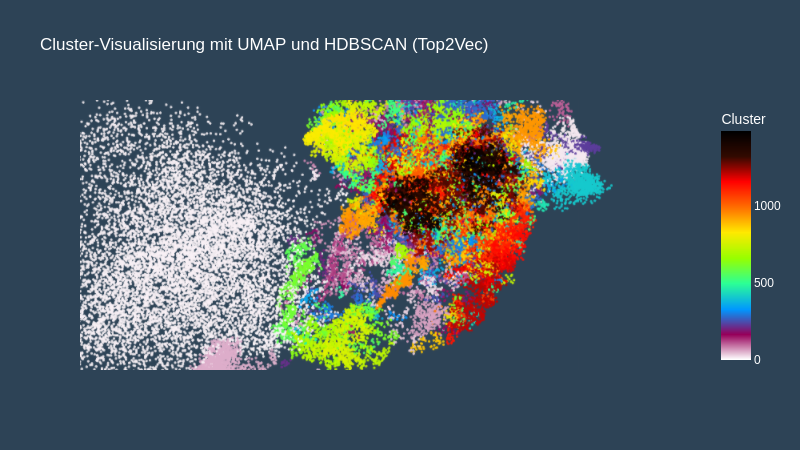

In [28]:
# Graphische Darstellung
# Farben
My_colors = ['rgb(255,255,255)', 'rgb(150,0,90)', 'rgb(0,152,255)',
             'rgb(44,255,150)', 'rgb(151,255,0)', 'rgb(255,234,0)',
             'rgb(255,111,0)', 'rgb(255,0,0)','rgb(50,10,0)', 'rgb(0,0,0)']

# Erstellen eines 3D Scatterplots für die Clusterpunkte
clustered_fig = px.scatter_3d(clustered_df, x='x', y='y', z='z', color='labels',
                    opacity=0.9,
                    color_continuous_scale= My_colors,
                    title='Cluster-Visualisierung mit UMAP und HDBSCAN (Top2Vec)',
                    labels={'labels': 'Cluster'})

# Hinzufügen eines 3D Scatterplots für die Ausreißer
#outlier_fig = px.scatter_3d(outliers_df, x='x', y='y', z='z', color='labels', opacity=0.09)
#clustered_fig.add_trace(outlier_fig.data[0])

# Optische Anpassungen
# Marker
clustered_fig.update_traces(marker_size=1.5)

# Achsen
clustered_fig.update_layout(scene = dict(
                                xaxis = dict(backgroundcolor="#2D4356", gridcolor="#2D4356", zerolinecolor="#2D4356", tickfont=dict(color="#2D4356"), title=""),
                                yaxis = dict(backgroundcolor="#2D4356", gridcolor="#2D4356", zerolinecolor="#2D4356", tickfont=dict(color="#2D4356"), title="",),
                                zaxis = dict(backgroundcolor="#2D4356", gridcolor="#2D4356", zerolinecolor="#2D4356", tickfont=dict(color="#2D4356"), title="")))

# Layout
clustered_fig.update_layout(scene_camera=dict(eye=dict(x=0.1, y=-0.6, z=0)),
                            plot_bgcolor='#2D4356',
                            paper_bgcolor='#2D4356',
                            font_color='white')

# Speichern in einem HTML File
clustered_fig.write_html("Top2Vec_3D_Clustering.html")

# Ausgabe
gitly.show(clustered_fig)

### 4.3. Modellierung
#### __Initialisierung des Modells und Anwendung auf den Datensatz__

Die Implementierung von Top2Vec ist sehr einfach gestalltet. Die Initialisierung und Durchführung des Modells erfolgt in einer einzigen Codezeile. Hierfür werden die Unbereinigten Sätze an das Modell übergeben und das Embedding über den Parameter "embedding_model" gestgelegt. Im Rahmen der Masterarbeit wurde der für Top2Vec vorgesehene Algorithmus von "Doc2Vec" herangezogen. Die übrigen Parameter sind lediglich zu Veranschauungszwecken mit aufgeführt, müssten aber aufgrund der implementierung der Default Werte nicht angegeben werden (Sphinx, 2020).

In [29]:
# Create jointly embedded topic, document and word vectors
# Quelle: https://towardsdatascience.com/topic-modeling-with-lsa-plsa-lda-nmf-bertopic-top2vec-a-comparison-5e6ce4b1e4a5#78f7
model_top2vec = Top2Vec(sentence_list,                        # Liste der zu untersuchenden Texte
                        embedding_model = 'doc2vec',          # Verwendetes Embedding Model
                        min_count = 50,                       # Excludieren der Wörter, welche eine geringere Frequenz haben
                        umap_args=None,                       # Verwendung der Default Werte von UMAP
                        hdbscan_args=None,                    # Verwendung der Default Werte von HDBSCAN
                        verbose=True)                         # Progressbar

2023-08-08 19:10:44,700 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2023-08-08 19:10:57,997 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2023-08-08 19:23:35,437 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2023-08-08 19:25:21,455 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2023-08-08 19:25:29,470 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


### 4.4.  Visualisierung
Mithilfe unterschiedlicher Funktionen lassen sich die wichtigsten Informationen aus dem Modell extrahieren.
Um ein Verständnis für die Häufigkeit der Schlüsselwörter zu bekommen bietet Top2Vec die Möglichkeit über die Funktion "generate_topic_wordcloud" eine Wordcoud für ein bestimmtes Topic zu erstellen (Mavuduru, 2021).

In [30]:
# Anzahl der Identifizierten Topics
# Quelle: https://top2vec.readthedocs.io/en/stable/Top2Vec.html#benefits
number_of_topics = model_top2vec.get_num_topics()
print(f"Mithilfe von Top2Vec wurden {number_of_topics} in den Review Daten identifiziert.")

Mithilfe von Top2Vec wurden 1299 in den Review Daten identifiziert.


In [31]:
# Ausgabe der ersten 10 Themen
# Quelle: https://top2vec.readthedocs.io/en/stable/Top2Vec.html#benefits
topic_words, word_scores, topic_nums = model_top2vec.get_topics(10)
topic_sizes, topic_nums = model_top2vec.get_topic_sizes()

# Speichern der Ergebnisse in einer Liste
result_list = []
for i in range(topic_words.shape[0]):
    element = [topic_nums[i], topic_sizes[i], topic_words[i][:10].tolist(), word_scores[i][:10].tolist()]
    result_list.append(element)

# Übertragen der Ergebisse in einen DataFrame
topics_df = pd.DataFrame(result_list, columns=["Topic_number", "Topic_Size" ,"Words", "Word_Properties"])

# Ausgabe
topics_df

,Topic_number,Topic_Size,Words,Word_Properties
0,0,1420,"[lasagna, delicious, tasty, bland, flavor, str...","[0.4503646194934845, 0.44371798634529114, 0.43..."
1,1,729,"[recommend, price, good, quality, overall, pur...","[0.6240373849868774, 0.6148366928100586, 0.608..."
2,2,647,"[lansky, stones, sharpening, stone, strop, hon...","[0.5127484202384949, 0.4857501685619354, 0.480..."
3,3,628,"[hatchet, fiskars, hatchets, logs, chopping, a...","[0.5519116520881653, 0.4809369742870331, 0.467..."
4,4,605,"[mirrors, mirror, mirrycle, view, traffic, con...","[0.5180653929710388, 0.5078448057174683, 0.504..."
5,5,589,"[mat, yoga, manduka, mats, jade, poses, studio...","[0.6565179824829102, 0.6472768783569336, 0.629..."
6,6,561,"[helmet, helmets, giro, visor, crash, ventilat...","[0.5758181214332581, 0.5715436935424805, 0.538..."
7,7,560,"[elbow, flexbar, tennis, tendonitis, thera, go...","[0.5172356963157654, 0.5164740085601807, 0.511..."
8,8,541,"[coolers, cooler, igloo, ice, drinks, yeti, dr...","[0.5722463130950928, 0.5524386167526245, 0.527..."
9,9,541,"[frisbee, frisbees, disc, aerobie, discs, flie...","[0.6135310530662537, 0.5793858766555786, 0.512..."


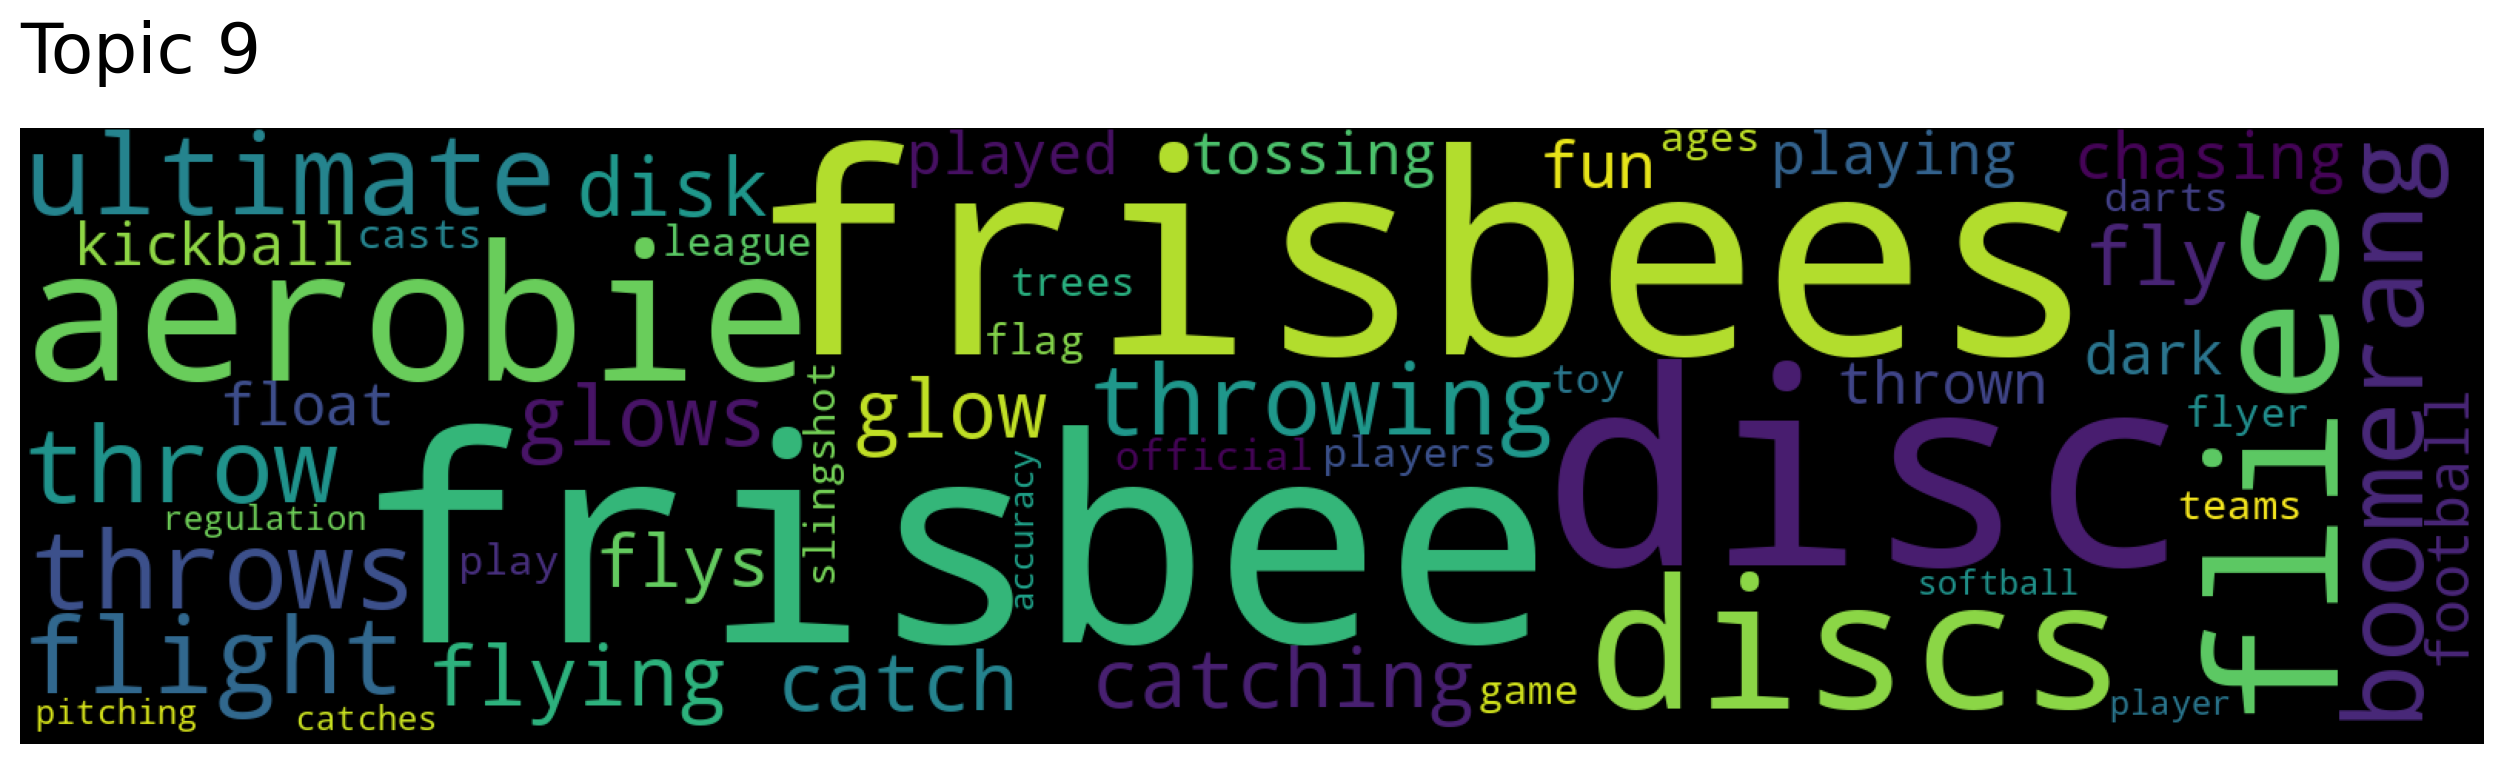

In [37]:
# Wordcloud repräsentativ für Topic 9
model_top2vec.generate_topic_wordcloud(9)

## 5. Evaluierung

Um die Topic Modelling Modelle bewerten zu können, ist es wichtig geeignete Metriken und Validierungsmöglichkeiten heranzuziehen. Auf diese Weise lässt sich herausfinden wie gut die Themenklassifizierung funktioniert hat (Pascual, Topic Modeling: An Introduction, 2019). Im Allgemeinen lassen sich zwei verschiedenen Herangehensweisen unterscheiden: die Intrinsische und die extrinsische Clustervalidität.Im Rahmen dieser Masterarbeit wird auf intrinsische Clustervaliditätsmetriken zurückgegriffen, welche strukturelle Eigenschaften der Cluster berücksichtigt und semantische Merkmale vergleichen (Rüdiger, Antons, Joshi, & Salge, 2022).

Befor mit der Anwendung der Evaluierungsmetriken begonnen werden kann, müssen die notwendigen Parameter dafür erzeugt werden.

In [38]:
# Vorverarbeitungsschritte für die Paramtert der Evaluierungsmodelle
# Quelle: https://stackoverflow.com/questions/64275581/how-to-solve-attributeerror-top2vec-object-has-no-attribute-topic-sizes
# Erzeugen einer Liste mit den ersten 10 Topics und deren Anzahl an Reviews leeren Liste
topic_size_list = topics_df[["Topic_number", "Topic_Size"]].values.tolist()
documents_list = []

# Erstellen einer Liste mit den bereinigten Review Daten und deren Topic Nummer
for topic in topic_size_list:
  documents, document_scores, document_nums = model_top2vec.search_documents_by_topic(topic_num=topic[0], num_docs=topic[1])
  for i in range(documents.shape[0]):
    element = [topic[0], documents[i]]
    documents_list.append(element)

# Speichern in einen DataFrame
documents_df = pd.DataFrame(documents_list, columns=["Topic_number", "Document"])

# Gruppieren der Dokumente je Topic
documents_per_topic = documents_df.groupby(['Topic_number'], as_index=False).agg({'Document': ' '.join})

# Bilden einer Liste aller Sätze pro Topic
cleaned_docs = documents_per_topic.Document.to_list()

In [39]:
# Vorbereitung der Parameter für den Kohärenzscore
# Quelle: https://www.theanalyticslab.nl/topic-modeling-with-bertopic/
token_list = reviews_df.Token.to_list()                             # Extraktion der Tokens mithilfe des Analysers
dictionary = corpora.Dictionary(token_list)                         # Erstellung des Wörterbuchs aus den Token
corpus = [dictionary.doc2bow(token) for token in token_list]        # Erstellung des BoW Korpus mithilfe der Token und des Dictionaries
topic_list = topics_df.Words.to_list()                              # Erstellen einer Liste mit den wichtigsten Wörtern des Topics

### 5.1.1. Coherence Score
Die Kohärenz bezieht sich auf die semitische Verbundenheit der Wörtern, wodurch Sinnbeziehungen in einem Text entstehen, was auf den Leser semantisch konsistent und logisch wirkt (Rüdiger, Antons, Joshi, & Salge, 2022). Verallgemeinert gesagt ist eine Aussage kohärent, wenn sich die Inhalte gegenseitig stützen (Kapadia, 2019).



#### __Durchschnittlicher Coherence Score des Modells__

Wie bereits in der theoretischen Ausarbeitung dieser Masterarbeit beschrieben, stellt der Kohärenzscore eines Modells die aggregierten Themenkohärenzen der einzelnen Topics dar und gibt Aufschluss darüber wie gut das Modell die Sinnbeziehungen der gesammten Reviews erkannt und geclustert hat. Das Ergebnis kann zwischen 0 und 1 liegen und je mehr dieses sich der 1 annähert, desto höher ist die semantische Verbundeheit der Wörter und Themen (Pedro, 2022).

In [40]:
# Initialisierung des Kohärenzmodells
coherence_model = CoherenceModel(topics=topic_list,
                                 texts=token_list,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_v')

# Ermittlung des Kohärenzscores
coherence = coherence_model.get_coherence()

# Ausgabe
print('Coherence Score von LSA beträgt: ', coherence)

Coherence Score von LSA beträgt:  0.6073362050001057


#### __Themenkohärenz__

Mithilfe von Themenkohärenzmaße lässt sich die Ähnlichkeit der Wörter in Bezug auf ein bestimmtes Thema messen (Kapadia, 2019). Auf diese Weise können die Topics identifiziert werden, welche semantisch schlüssig interpretiert werden können.
Hier gilt ebenfalls: Je höher der Score, desto höher die Ähnlichkeit der Wörter im Cluster.

In [41]:
# Kohärenz Score pro Topic ermitteln
coherence_per_topic = coherence_model.get_coherence_per_topic()

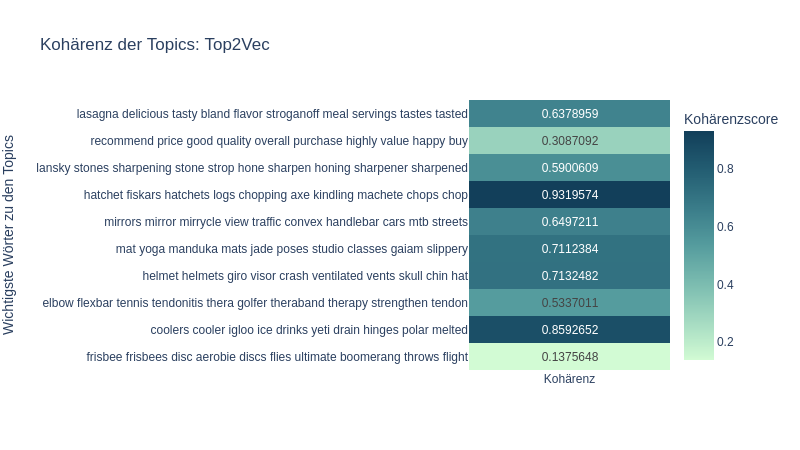

In [42]:
# Graphische Darstellung
# Speichern der Themenkohörenz und der Topics in einem DataFrame
score_per_topic_df = pd.DataFrame( data=zip(topic_list, coherence_per_topic), columns=['Topic', 'Kohärenz'])

# Umwandeln der Topics in einen string
for index, row in score_per_topic_df.iterrows():
  score_per_topic_df.at[index,"Topic"] = " ".join(row.Topic)

# Setzten des der Liste von Wörter (der Topics) als Index
score_per_topic_df = score_per_topic_df.set_index('Topic')

# Darstellung der Themenkohärenz in einer Heatmap
fig_topic_coherence = px.imshow(score_per_topic_df, text_auto=True, aspect="auto", color_continuous_scale=px.colors.sequential.Darkmint, title = "Kohärenz der Topics: Top2Vec",
                                labels = dict(color = "Kohärenzscore", y = "Wichtigste Wörter zu den Topics"), height = 600, width = 800)


# Speichern in einem HTML File
fig_topic_coherence.write_html("Top2Vec_Coherence.html")

# Ausgabe
gitly.show(fig_topic_coherence)

### 5.1.2. Perplexity

Die Perplexity gibt Aufschluss darüber wie gut ein Modell neue Daten verallgemeinern und vorhersagen kann, indem es den Abstand der Themenverteilung des Modells und der gleichmäßigen Wortverteilung des erstellten Wörterbuches misst (Rüdiger, Antons, Joshi, & Salge, 2022). Ein Modell hat ein „gutes Verständnis“ über eine Sprache, wenn es ein semantisch korrektes und häufig auftretendes Wort eine hohe Wahrscheinlichkeit zuweist und einem Seltenem eine niedrige Wahrscheinlichkeit. Aufgrund der umgekehrten Wahrscheinlichkeit, ist eine geringe Perplexity als eine hohe Performence des Modells zu interpretieren (Campagnola, 2020).

In [43]:
# Erechnung der logaritmische Perplexity
# Quelle: https://huggingface.co/docs/transformers/perplexity
log_perplexity = -1 * np.mean(np.log(np.sum(vector_list)))

perplexity = np.exp(log_perplexity)

# Ausgabe
print('Die Perplexity für Top2Vec beträgt: ', perplexity)

Die Perplexity für Top2Vec beträgt:  2.1329459962240444e-05


### 5.1.3. Similarity

Die „Cosine Similarity“ gibt ein Maß für die Ähnlichkeit zweier Vektoren wieder, welche sich in einem mehrdimensionalen Raum befinden. Der Score basiert auf dem Kosinus der Winkelmessung und bezieht sich auf die Orientierung der Vektoren im Raum anstatt auf deren Länge(Sitikhu, Pahi, Thapa, & Shakya, 2019, S. 2).
Das Ergebnis der Kosinusähnlichkeit kann zwischen -1 und 1 liegen. Wenn ein Winkel zwischen zwei Vektoren klein ist, tendiert der Kosinus des Winkels gegen eins, was sich als ein hohes Maß an Ähnlichkeit interpretieren lässt. Je größer der Winkel wird, desto unähnlicher sind sich die Dokumente. Bei 90° und einem Kosinus Wert um null spricht man von orthogonalen Vektoren. Nimmt Kosinus den Wert -1 an, so nähert sich deren Winkel 180° und die Reviews bzw. Wörter sind mit einem gegenteiligen Inhalt zu interpretieren (Supe, 2023).

Befor die Similarity Scores berechnet werden können, müssen die Daten noch in das passende Format transformiert werden:

In [ ]:
# Extraktion der Vektoren für die Reviews der 10 wichtigsten Topics
# Quelle: https://medium.com/@mishra.thedeepak/doc2vec-simple-implementation-example-df2afbbfbad5
# Speichern der Sätze der 10 wichtigsten Topics in einer Liste
sentence_10_list = documents_df.Document.values.tolist()

# Taggen der Dokumente
tagged_10_list = [TaggedDocument(words=doc, tags=[str(i)]) for i, doc in enumerate(sentence_10_list)]

# Intialisierung des Modells (Doc2Vec)
embedding_model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4)
embedding_model.build_vocab(tagged_10_list)
embedding_model.train(tagged_10_list, total_examples=embedding_model.corpus_count, epochs=100)

vector_10_list = []

# Erstellen der Embeddings
for i in range(len(sentence_10_list)):
    vector = embedding_model.docvecs[str(i)].tolist()
    vector_10_list.append(vector)

In [45]:
# Erstellen der Gruppierung der Vektoren pro Topic
# Hinzufügen der Vektoren zu den Dokumentendaten
documents_df["Vector"] = vector_10_list

# Erstellen einer leeren Liste für die Vectoren
vector_dict = {}

# Extrahieren der Topics
topics_unique = np.sort(documents_df.Topic_number.unique())

# Befüllen des Dictionaries mit den Vectoren pro Topic
for topic in topics_unique:
  vector_dict[str(topic)] = documents_df.loc[documents_df["Topic_number"] == topic].Vector.tolist()

#### __Similarity zwischen den Reviews eines Topics__

Um zu identifizieren, ob sich die Reviews innerhalb eines Topics ähndeln und somit auf einen gleichen Inhalt geschlussfolgert werden kann, wird im folgeden der Similarity Score zwischen den Reviews innerhalt eines Topics berechnent.
Je weiter die Werte gegen 1 tendieren, desto ähnlicher sind die Reviews, welche diesem Topic zugeordnet wurden (Supe, 2023).

In [46]:
# Similarity Scores pro Topic
# Quelle: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
# Erstellen eines DataFrames
similarity_df = pd.DataFrame(topics_unique, columns=["Topic_number"])
similarity_df["Similarity"] = ""

# Schleife zur Errechnung des Similarity Scores pro Topic
for key in vector_dict:
  similarity = cosine_similarity(vector_dict[key]).mean()
  similarity_df.loc[similarity_df["Topic_number"] == int(key), "Similarity"] = similarity

# Konvertierung der Spalten in das richtige Datenformat
similarity_df["Topic_number"] = similarity_df["Topic_number"].astype(str)
similarity_df["Similarity"] = similarity_df["Similarity"].astype(float)

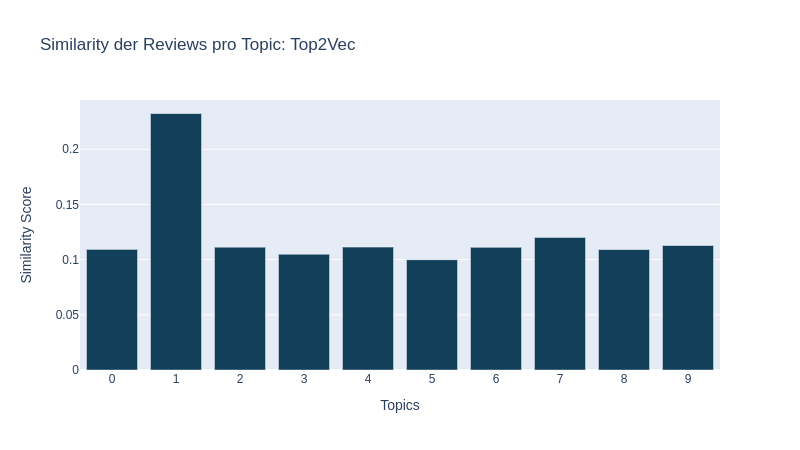

In [47]:
# Graphische Darstellung
similarity_fig = px.bar(similarity_df, x="Topic_number", y="Similarity", title="Similarity der Reviews pro Topic: Top2Vec",
                        color_discrete_sequence=px.colors.sequential.Darkmint_r)

# Update Layout
similarity_fig.update_xaxes(title_text= "Topics")
similarity_fig.update_yaxes(title_text= "Similarity Score")

# Speichern in ein HTML File
similarity_fig.write_html("Top2Vec_Similarity_per_Topic.html")

# Ausgabe
gitly.show(similarity_fig)

#### __Topic Similarity Matrix__

Mithilfe der Topic Similarity Matrix lassen sich ähnliche Topics identifizieren, welche sich mit ähnlichen Inhalten befassen. Die Abbildung wurde in Anlehnung an die "Topic Similarity Matrix" von BERTopic erstellt. Für die Ermittlung des Cosine Similarity Scores werden die Vektoren der Topics miteinander verglichen (Grootendorst, Heatmap, 2023). Die Diagonale bildet den Similarity Score des Topics ab, welches bereits im Schritt zuvor berechnet wurde.

In [48]:
# Erstellen der Topic Similarity Matrix
# Erstellen einer leeren Matrix
matrix_for_heat_map = np.zeros((10,10))

# Transformation des NumPy arrays zu einer Liste für schnelleren Loop
topics_unique = list(topics_unique)

# Loop über die Spalten und Zeilen zur Befüllung der Matrix
for col in range(len(topics_unique)):
  for row in range(len(topics_unique)):
    # Errechnung des durchschnittlichen Simiarity Scores
    similarity_between_topics = cosine_similarity(vector_dict[str(topics_unique[col])],
                                                  vector_dict[str(topics_unique[row])]).mean()
    # Hinzufügen des Scores in die Matrix
    matrix_for_heat_map[row,col] = similarity_between_topics

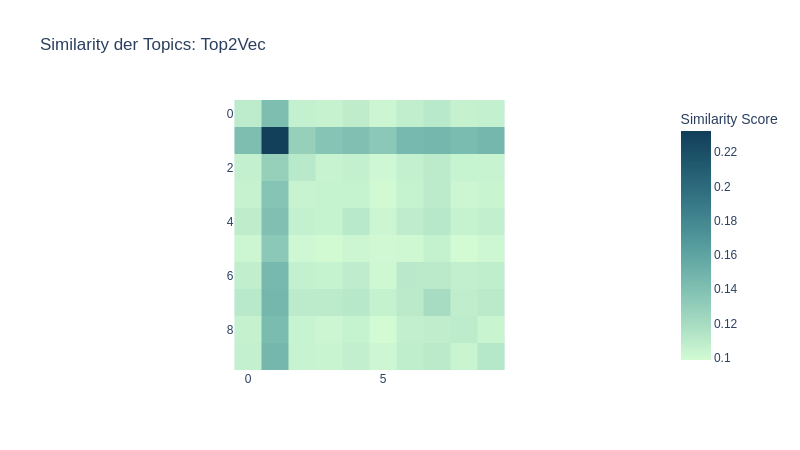

In [49]:
# Graphische Darstellung
similarity_topics_fig = px.imshow(matrix_for_heat_map, title="Similarity der Topics: Top2Vec",
                                  labels=dict(color="Similarity Score"),
                                  width= 600,
                                  color_continuous_scale=px.colors.sequential.Darkmint)

# Speichern in ein HTML File
similarity_topics_fig.write_html("Top2Vec_Similarity_between_Topic.html")

# Ausgabe
gitly.show(similarity_topics_fig)

#### __Intertopic Distanz der Topics__

Mithilfe der Intertopic Distanz Map lässt sich die Entfernung zwischen den Themen messen. Je ähnlicher sich die Themen sind, desto näher liegen diese beieinander und können sich sogar überlappen, falls diese teilweise identische Inhalte aufweisen. Je weiter die Blasen in dem Diagramm voneinander entfernt sind, desto mehr unterscheiden sich die Themen voneinander. Die Größe der Kreise repräsentieren die Anzahl der im Topic enthaltenen Reviews (Amy, 2022). Während andere Modelle, wie BERTooic oder LDA eine derartige Darstellung standardmäßig implementiert haben, wurde für LSA eine vergleichbare Darstellung manuell erstellt. Die Logik orientiert sich an den Berechnungen von BERTopic (Grootendorst, Topics, 2023).

In [ ]:
# Erstellen der Intertopic Distanz Map (Inspiriert von BERTopic)
# Quelle: https://maartengr.github.io/BERTopic/api/plotting/topics.html#bertopic.plotting._topics.visualize_topics
# Speichern der Vektoren in einer Liste
embeddings = documents_df.Vector.values.tolist()

# Auf eine Zweidimensionale Ebene bringen
embeddings_2D = UMAP(n_neighbors=2, n_components=2, metric='cosine', random_state=42, verbose=True).fit_transform(embeddings)

# Hinzufügen der Spalten in den DataFrame "documents_df"
documents_df = documents_df.assign(x=embeddings_2D[:, 0], y=embeddings_2D[:, 1])

In [51]:
# Gruppieren nach 'Topic_number' und Aggregation der x und y Vektoren
frequency_df = documents_df.groupby('Topic_number').agg(count=('Topic_number', 'count'),
                                                        x_mean=('x', 'mean'),
                                                        y_mean=('y', 'mean')).reset_index()

# Konvertieren der Topic_number in das richtige Format
frequency_df["Topic_number"] = frequency_df["Topic_number"].astype(str)
topics_df["Topic_number"] = topics_df["Topic_number"].astype(str)

# Ergänzen um die Namen der Topics und deren Wahrscheinlichkeiten
frequency_df = frequency_df.merge(topics_df, on="Topic_number", how="left")

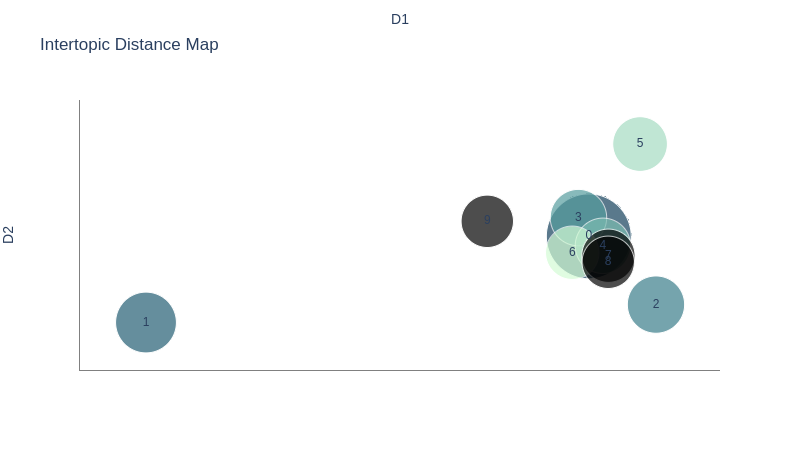

In [52]:
# Graphische Darstellung
intertopic_distanz_fig = px.scatter(frequency_df, x="x_mean", y="y_mean",
                                    size = "count",
                                    hover_name = "Words",
                                    text="Topic_number",
                                    size_max = 60,
                                    width= 600,
                                    height= 600,
                                    title = "Intertopic Distance Map")

# Layout updaten
intertopic_distanz_fig.update_traces(marker=dict(color=px.colors.sequential.Darkmint_r))
intertopic_distanz_fig.update_layout(plot_bgcolor="white",
                                     paper_bgcolor="white",

                                     showlegend=False)

# x- und y-Achse Updaten
intertopic_distanz_fig.update_xaxes(showline=True, linewidth=1, linecolor='grey', showticklabels=False, title= "D1")
intertopic_distanz_fig.update_yaxes(showline=True, linewidth=1, linecolor='grey', showticklabels=False, title= "D2")

# Speichern in ein HTML File
intertopic_distanz_fig.write_html("Top2Vec_Intertopic_Distance_Map.html")

# Ausgabe
gitly.show(intertopic_distanz_fig)

#### __Hierarchisches Clustering__

Mithilfe dieser Visualisierungsform, lassen sich die  hierarchische Struktur der Topics visualisieren. Auf diese Weise lassen sich die Inhaltlichen Beziehungen von Themen identifizieren, welche miteinander Verbunden sind. Des weiteren werden Themengruppen erseichtlich sowie eine Strukturierung in Unter- und Überthemen. In Anlehnung an BERTopic wurde hierfür eine Ward-Linkage-Funktion von Plotly erstellt, welche die hierarchische Clusterbildung auf Basis der bereits berechneten Kosinus-Similarity-Distanzmatrix der Topics abbildet (Grootendorst, Hierarchy, 2023).

In [53]:
# Umwandeln der Topic Embeddings in ein 2 dimensionales Array
embeddings_array = frequency_df[['x_mean','y_mean']].to_numpy()

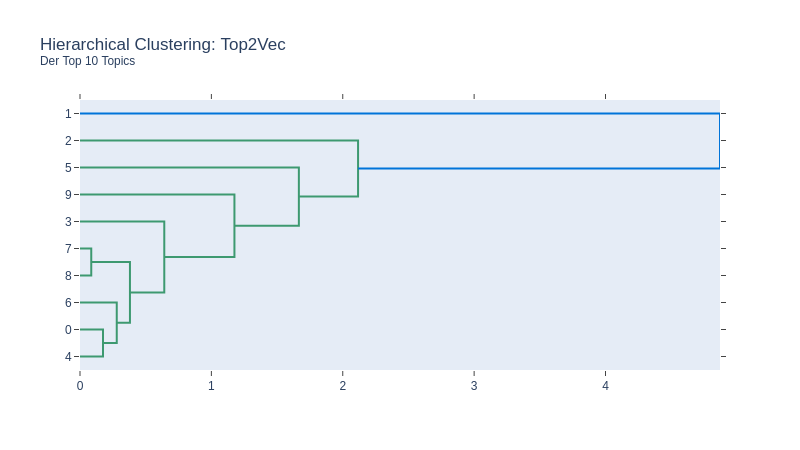

In [54]:
# Graphische Darstellung
# Quelle: https://maartengr.github.io/BERTopic/api/plotting/hierarchy.html#bertopic.plotting._hierarchy.visualize_hierarchy
# Quelle: https://plotly.com/python/dendrogram/
hierarchical_topics_fig = ff.create_dendrogram(embeddings_array,
                                               orientation="left")

# Update Laout
hierarchical_topics_fig.update_layout(title= "Hierarchical Clustering: Top2Vec <br><sup>Der Top 10 Topics</sup>")

# Speichern in einem HTML File
hierarchical_topics_fig.write_html("Top2Vec_Hierachical_Clustering.html")

# Ausgabe
gitly.show(hierarchical_topics_fig)

## 6. Literaturverzeichnis

Amy. (21. 10 2022). Topic Modeling with Deep Learning Using Python BERTopic. Abgerufen am 05. 08 2023 von medium.com: https://medium.com/grabngoinfo/topic-modeling-with-deep-learning-using-python-bertopic-cf91f5676504

Campagnola, C. (18. 05 2020). Perplexity in Language Models. Abgerufen am 24. 07 2023 von towardsdatascience.com: https://towardsdatascience.com/perplexity-in-language-models-87a196019a94

Grootendorst, M. (2023). Heatmap. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/heatmap.html#bertopic.plotting._heatmap.visualize_heatmap

Grootendorst, M. (2023). Hierarchy. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/hierarchy.html

Grootendorst, M. (2023). Topics. Abgerufen am 07. 08 2023 von maartengr.github.io: https://maartengr.github.io/BERTopic/api/plotting/topics.html

Grootendorst, M. (05. 10 2020). Topic Modeling with BERT. Abgerufen am 30. 04 2023 von towardsdatascience.com: https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

Kapadia, S. (19. 08 2019). Evaluate Topic Models: Latent Dirichlet Allocation (LDA). Abgerufen am 21. 06 2023 von towardsdatascience.com: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Le, Q., & Mikolov, T. (22. 05 2014). Distributed Representations of Sentences and Documents. Abgerufen am 11. 07 2023 von arxiv.org: https://arxiv.org/pdf/1405.4053.pdf

Mavuduru, A. (17. 11 2021). How to perform topic modeling with Top2Vec. Abgerufen am 10. 07 2023 von towardsdatascience.com: https://towardsdatascience.com/how-to-perform-topic-modeling-with-top2vec-1ae9bb4e89dc

McInnes, L., Healy, J., & Astels, S. (2016). HDBSCAN. Abgerufen am 02. 08 2023 von hdbscan.readthedocs.io: https://hdbscan.readthedocs.io/en/latest/api.html

Pascual, F. (26. 09 2019). Topic Modeling: An Introduction. Abgerufen am 13. 12 2022 von monkeylearn.com: https://monkeylearn.com/blog/introduction-to-topic-modeling/

Pedro, J. (10. 01 2022). Understanding Topic Coherence Measures. Abgerufen am 23. 06 2023 von towardsdatascience.com: https://towardsdatascience.com/understanding-topic-coherence-measures-4aa41339634c

Rüdiger, M., Antons, D., Joshi, A. M., & Salge, T.-O. (28. 04 2022). Topic modeling revisited: New evidence on algorithm performance and quality metrics. Abgerufen am 13. 06 2023 von journals.plos.org: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0266325

Sitikhu, P., Pahi, K., Thapa, P., & Shakya, S. (31. 10 2019). A Comparison of Semantic Similarity Methods for Maximum Human Interpretability. Abgerufen am 05. 08 2023 von Department of Electronics and Computer Engineering, Tribhuwan University: https://arxiv.org/pdf/1910.09129.pdf

Sphinx. (2020). Top2Vec. Abgerufen am 19. 07 2023 von top2vec.readthedocs.io: https://top2vec.readthedocs.io/en/stable/Top2Vec.html

Supe, K. (07. 06 2023). Understanding Cosine Similarity in Python with Scikit-Learn. Abgerufen am 05. 08 2023 von memgraph.com/: https://memgraph.com/blog/cosine-similarity-python-scikit-learn
